In [ ]:
!python --version
# python 3.7.12

Python 3.7.12


## **Installing Depencies**

In [ ]:
!pip install --upgrade tensorflow_hub
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 


In [ ]:
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 46.0 MB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 47.6 MB 33 kB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 596 kB 49.4 MB/s 
     |████████████████████████████████| 1.2 MB 34.2 MB/s 
     |████████████████████████████████| 213 kB 39.3 MB/s 
     |████████████████████████████████| 352 kB 49.7 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=ddc95b1e11f78a2c62fa9b8b0cecd5977a35386284c57c72fad34f075758e936
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=e8d65d5c28fae7ee8de0ae3e18403c3d791738635d0904ab8f4fbbc5ae81cbd7
  Stored in

**Getting the Dataset**

For this work the dataset is coming from Kaggle at this link: [Womens-ecommerce-clothing-reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/)

Content
This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:



*   Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
*   Age: Positive Integer variable of the reviewers age.
*   Title: String variable for the title of the review.
*   Review Text: String variable for the review body.
*   Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
*   Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
*   Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
*   Division Name: Categorical name of the product high level division.
*   Department Name: Categorical name of the product department name.
*   Class Name: Categorical name of the product class name.

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
data_O = pd.read_csv('/content/drive/MyDrive/INF_6323/Womens Clothing E-Commerce Reviews.csv')

In [ ]:
data_O.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df= data_O.rename(columns={'Review Text': 'review_body',
                                    'Rating': 'star_rating',
                                    'Class Name': 'product_category'})
df.drop(columns=['Clothing ID', 'Age', 'Title', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name'],
                    inplace=True)

df.dropna(inplace=True)

df.shape

(22628, 4)

In [ ]:
df.head()

,Unnamed: 0,review_body,star_rating,product_category
0,0,Absolutely wonderful - silky and sexy and comf...,4,Intimates
1,1,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,2,I had such high hopes for this dress and reall...,3,Dresses
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants
4,4,This shirt is very flattering to all due to th...,5,Blouses


In [ ]:
def to_sentiment(star_rating):
    if star_rating in {1, 2, 3}: # negative
        return -1 
    if star_rating == 3:      # neutral
        #return 0
    if star_rating in {4, 5}: # positive
        return 1

# transform star_rating into the sentiment
df['sentiment'] = df['star_rating'].apply(lambda star_rating: 
    to_sentiment(star_rating=star_rating) 
)

# drop the star rating column
df.drop(columns=['star_rating'],
                    inplace=True)

# remove reviews for product_categories with < 10 reviews
df_filtered = df.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['sentiment', 'review_body', 'product_category']]

df_filtered.shape

(22626, 3)

In [ ]:
df_filtered.head()

,sentiment,review_body,product_category
0,1,Absolutely wonderful - silky and sexy and comf...,Intimates
1,1,Love this dress! it's sooo pretty. i happene...,Dresses
2,-1,I had such high hopes for this dress and reall...,Dresses
3,1,"I love, love, love this jumpsuit. it's fun, fl...",Pants
4,1,This shirt is very flattering to all due to th...,Blouses


**Balanced the dataset**

In [ ]:
df_grouped_by = df_filtered.groupby(['product_category', 'sentiment'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

In [ ]:
df_balanced

sentiment  ... product_category
product_category sentiment                ...                 
Blouses          -1        0          -1  ...          Blouses
                           1          -1  ...          Blouses
                           2          -1  ...          Blouses
                           3          -1  ...          Blouses
                           4          -1  ...          Blouses
...                                  ...  ...              ...
Trend             1        14          1  ...            Trend
                           15          1  ...            Trend
                           16          1  ...            Trend
                           17          1  ...            Trend
                           18          1  ...            Trend

[684 rows x 3 columns]

**Visualize the balanced dataset**

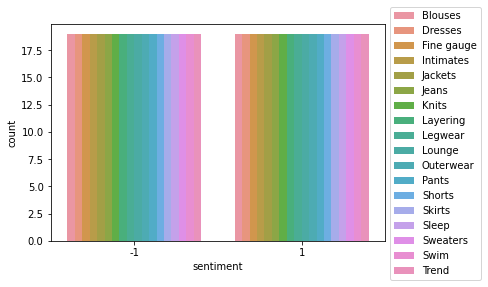

In [ ]:
import seaborn as sns

sns.countplot(data=df_balanced, x='sentiment', hue='product_category')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))
plt.show()

# **Splitting the datasets**

In [ ]:
X = df_balanced.review_body.values
y = df_balanced.sentiment.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert Layers
text_Input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_Input)
outputs = bert_encoder(preprocessed_text)
# Neural network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)
# construct the final model
model = tf.keras.Model(inputs=[text_Input], outputs=[l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 6  # select based on your GPU resources

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs, verbose=1)

Epoch 1/100
92/92 [==============================] - 16s 179ms/step - loss: 0.6516 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: -0.3647 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
92/92 [==============================] - 15s 165ms/step - loss: 0.5833 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: -0.4941 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
92/92 [==============================] - 15s 165ms/step - loss: 0.2812 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: -0.6045 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
92/92 [==============================] - 15s 164ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: -0.7370 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e